### import data and libraries

In [411]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import joblib
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [274]:
# import data
train = pd.read_csv('./data/train.csv')
valid = pd.read_csv('./data/validation.csv')
test  = pd.read_csv('./data/test.csv')

# 1. Preprocessing

In [480]:
# load all functions from module A3_Preprocessing 
%run A_Preprocessing

## 1.1 preprocess data for linear model

In [276]:
# parameters for data preprocessing

# irrelevant features
irrelevant_cols = ['bidprice','payprice', 'bidid', 'userid', 'url', 'urlid', 'domain', 'IP', 'slotid']

# continuous/ordinal features
cont_cols = ['slotwidth', 'slotheight', 'slotarea', 'slotprice']

# categorical features
cat_cols = ['adexchange', 'advertiser', 'city', 'creative', 'hour',
            'keypage', 'region', 'slotformat',  'slotvisibility',
            'weekday', 'system', 'browser']

# continuous/ordinal features to be assigned into bins
cont_to_bin_cols = ['slotprice']
bins = [[0, 0.00001, 20, 60, 301]]  # max slotprice = 0, min slotprice = 300

In [278]:
%%time
data, train_data, valid_data, test_data = preprocessing(irrelevant_cols, cont_cols, cat_cols, cont_to_bin_cols, bins,
                                                       train, valid, test)

CPU times: user 1min, sys: 23.7 s, total: 1min 23s
Wall time: 1min 26s


In [279]:
# downsample majority class
minority_class = 0.2
train_dsp = downsampling_majority_class(train_data, class_ratio=minority_class, seed=500)

The initial dataset has following sizes for each class:
0.0    2429188
1.0       1793
Name: click, dtype: int64
Minority class is 0.07% of initial sample size.
New dataset has following sizes for each class:
0.0    7172
1.0    1793
Name: click, dtype: int64
Minority class is 20.00% of total sample size.


In [613]:
# downsampling rate:
w = 7172 / 2429188
w

0.0029524269014995956

In [280]:
train_dsp_002 = downsampling_majority_class(train_data, class_ratio=0.02, seed=500)

The initial dataset has following sizes for each class:
0.0    2429188
1.0       1793
Name: click, dtype: int64
Minority class is 0.07% of initial sample size.
New dataset has following sizes for each class:
0.0    87857
1.0     1793
Name: click, dtype: int64
Minority class is 2.00% of total sample size.


## 1.2 preprocess data for tree-based model

In [492]:
# parameters for data preprocessing

# irrelevant features
irrelevant_cols = ['bidprice','payprice', 'bidid', 'userid', 'url', 'urlid', 'domain', 'IP', 'slotid'] 

# continuous/ordinal features
cont_cols = ['slotwidth', 'slotheight', 'slotarea', 'slotprice']

# categorical features
cat_cols = ['adexchange', 'advertiser', 'city', 'creative', 'hour',
            'keypage', 'region', 'slotformat',  'slotvisibility',
            'weekday', 'system', 'browser'] # + 

# continuous/ordinal features to be assigned into bins
cont_to_bin_cols = ['slotprice']
bins = [[0, 0.00001, 20, 60, 301]]  # max slotprice = 0, min slotprice = 300

###  test out if lightgbm convert categorical data correctly

In [493]:
# test out if lightgbm convert categorical data correctly
data_t = preprocessing_t(irrelevant_cols, cont_cols, cat_cols, cont_to_bin_cols, bins,
                                                       train, valid, test)

In [487]:
def convt_cat(X_all, feat):
    """
    convert string values of categorical feature to int
    
    input:
    @X_all(df): original dataset
    @feat(str): name of the feautre to be converted
    return:
    @feat_int(Series of int): integer representation of the categorical feature
    """    
    cat_series = pd.Series(X_all[feat], dtype='category', name=feat)
    num_cat = len(set(X_all[feat]))
    feat_int = cat_series.cat.rename_categories([x for x in range(num_cat)])
    
    return feat_int
   

In [495]:
# digit-labeling categorical features
for ft in cat_cols:
    data_t[ft] = convt_cat(data_t, ft)

In [496]:
# split data
train_data_t, valid_data_t, test_data_t = split_data(data_t2, train, valid, test)

In [497]:
# downsample majority class
minority_class = 0.2
train_dsp_t = downsampling_majority_class(train_data_t, class_ratio=minority_class, seed=500)

The initial dataset has following sizes for each class:
0.0    2429188
1.0       1793
Name: click, dtype: int64
Minority class is 0.07% of initial sample size.
New dataset has following sizes for each class:
0.0    7172
1.0    1793
Name: click, dtype: int64
Minority class is 20.00% of total sample size.


In [450]:
# test with default gbm 

# data for fitting
# X_train = train_data.drop(['click'], axis=1)
X_valid_t = valid_data_t.drop(['click'], axis=1)
X_train_dsp_t = train_dsp_t.drop(['click'], axis=1)
# X_train_dsp_002 = train_dsp_002.drop(['click'], axis=1)


# y_train = train_data['click']
y_valid_t = valid_data_t['click']
y_train_dsp_t = train_dsp_t['click']
# y_train_dsp_002 = train_dsp_002['click']

X_test_t = test_data_t.drop(['click'], axis=1)

# store data in Dataset object
# lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_train_dsp_t = lgb.Dataset(X_train_dsp_t, label=y_train_dsp_t)
# lgb_train_dsp_002 = lgb.Dataset(X_train_dsp_002, label=y_train_dsp_002)
lgb_valid_t = lgb.Dataset(X_valid_t, label=y_valid_t)

# minor change in default parameters
params = {
    'boosting' : 'gbdt', # @'rf'
    'objective' : 'regression_l2', # 'regression_l1'
    'num_leaves' : 31,
    'bagging_fraction' : 1.0,
    'feature_fraction' : 1.0,
    # change default
    'metric' : 'auc',
    'is_unbalanced': True
}

# downsampled
gbm_best_t = lgb.train(params, lgb_train_dsp_t, num_boost_round=30, valid_sets=lgb_valid_t, early_stopping_rounds=5)


/Users/fangzhenghu/Documents/Tools/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's auc: 0.862114
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.870925
[3]	valid_0's auc: 0.874632
[4]	valid_0's auc: 0.877609
[5]	valid_0's auc: 0.874761
[6]	valid_0's auc: 0.876613
[7]	valid_0's auc: 0.874879
[8]	valid_0's auc: 0.879446
[9]	valid_0's auc: 0.879092
[10]	valid_0's auc: 0.881706
[11]	valid_0's auc: 0.883023
[12]	valid_0's auc: 0.884623
[13]	valid_0's auc: 0.882925
[14]	valid_0's auc: 0.882432
[15]	valid_0's auc: 0.881423
[16]	valid_0's auc: 0.881038
[17]	valid_0's auc: 0.882034
Early stopping, best iteration is:
[12]	valid_0's auc: 0.884623


# 2. Model Selection

In [543]:
# load all functions from module B3_Model_Selection
%run B_Model_Selection

In [281]:
# data for fitting
X_train = train_data.drop(['click'], axis=1)
X_valid = valid_data.drop(['click'], axis=1)
X_train_dsp = train_dsp.drop(['click'], axis=1)
X_train_dsp_002 = train_dsp_002.drop(['click'], axis=1)


y_train = train_data['click']
y_valid = valid_data['click']
y_train_dsp = train_dsp['click']
y_train_dsp_002 = train_dsp_002['click']

X_test = test_data.drop(['click'], axis=1)

## 2.1 Optimize Logistic Regression

### load optimal model

In [283]:
lg = LogisticRegression(C=0.01, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           solver='liblinear', tol=1, verbose=0, warm_start=False)

In [284]:
lg.fit(X_train_dsp_002, y_train_dsp_002)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=1, verbose=0, warm_start=False)

In [285]:
roc_auc_score(y_valid, lg.predict_proba(X_valid)[:,1])

0.8577306452013026

### logs

In [18]:
%%time
params = {'C': [0.05, 0.1, 1],
          'penalty': ['l1', 'l2'],
          'class_weight': [None, 'balanced'],
          'tol': [0.005, 0.01, 0.1]}

best_model_lg_dsp, best_score_lg_dsp = optimize_log_reg(params_tmp, X_train_dsp, y_train_dsp, X_valid, y_valid)

CPU times: user 38.2 s, sys: 21 s, total: 59.2 s
Wall time: 50.2 s


In [364]:
# downsample with minority = 0.2
best_score_lg_dsp, best_model_lg_dsp

(0.8574009577447506,
 LogisticRegression(C=0.1, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           solver='liblinear', tol=0.01, verbose=0, warm_start=False))

In [28]:
# downsample with minority = 0.02
best_score_lg_dsp_002, best_model_lg_dsp_002

(LogisticRegression(C=0.01, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           solver='liblinear', tol=1, verbose=0, warm_start=False),
 0.8576626360594396)

## 2.2 *Optimize Gradient Boosting Models
ref: https://github.com/Microsoft/LightGBM/issues/695

### run model with default setting

In [500]:
# test with default gbm 

# data for fitting
# X_train = train_data.drop(['click'], axis=1)
X_valid_t = valid_data_t.drop(['click'], axis=1)
X_train_dsp_t = train_dsp_t.drop(['click'], axis=1)
# X_train_dsp_002 = train_dsp_002.drop(['click'], axis=1)


# y_train = train_data['click']
y_valid_t = valid_data_t['click']
y_train_dsp_t = train_dsp_t['click']
# y_train_dsp_002 = train_dsp_002['click']

X_test_t = test_data_t.drop(['click'], axis=1)

# store data in Dataset object
# lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_train_dsp_t = lgb.Dataset(X_train_dsp_t, label=y_train_dsp_t)
# lgb_train_dsp_002 = lgb.Dataset(X_train_dsp_002, label=y_train_dsp_002)
lgb_valid_t = lgb.Dataset(X_valid_t, label=y_valid_t)

# minor change in default parameters
params = {
    'boosting' : 'gbdt', # @'rf'
    'objective' : 'regression_l2', # 'regression_l1'
    'num_leaves' : 31,
    'bagging_fraction' : 1.0,
    'feature_fraction' : 1.0,
    # change default
    'metric' : 'auc',
    'is_unbalanced': True
}

# downsampled
gbm_best_t = lgb.train(params, lgb_train_dsp_t, num_boost_round=30, valid_sets=lgb_valid_t, early_stopping_rounds=5)


/Users/fangzhenghu/Documents/Tools/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's auc: 0.862114
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.870925
[3]	valid_0's auc: 0.874632
[4]	valid_0's auc: 0.877609
[5]	valid_0's auc: 0.874761
[6]	valid_0's auc: 0.876613
[7]	valid_0's auc: 0.874879
[8]	valid_0's auc: 0.879446
[9]	valid_0's auc: 0.879092
[10]	valid_0's auc: 0.881706
[11]	valid_0's auc: 0.883023
[12]	valid_0's auc: 0.884623
[13]	valid_0's auc: 0.882925
[14]	valid_0's auc: 0.882432
[15]	valid_0's auc: 0.881423
[16]	valid_0's auc: 0.881038
[17]	valid_0's auc: 0.882034
Early stopping, best iteration is:
[12]	valid_0's auc: 0.884623


In [507]:
# gbm result
roc_auc_score(y_valid, gbm_best_t.predict(X_valid_t))

0.8846227801433061

In [811]:
# test with default gbm 

# data for fitting
# X_train = train_data.drop(['click'], axis=1)
X_valid_t = valid_data_t.drop(['click'], axis=1)
X_train_dsp_t = train_dsp_t.drop(['click'], axis=1)
# X_train_dsp_002 = train_dsp_002.drop(['click'], axis=1)


# y_train = train_data['click']
y_valid_t = valid_data_t['click']
y_train_dsp_t = train_dsp_t['click']
# y_train_dsp_002 = train_dsp_002['click']

X_test_t = test_data_t.drop(['click'], axis=1)

# store data in Dataset object
# lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_train_dsp_t = lgb.Dataset(X_train_dsp_t, label=y_train_dsp_t)
# lgb_train_dsp_002 = lgb.Dataset(X_train_dsp_002, label=y_train_dsp_002)
lgb_valid_t = lgb.Dataset(X_valid_t, label=y_valid_t)

# minor change in default parameters
params = {
    'boosting' : 'gbdt', # @'rf'
    'objective' : 'regression_l2', # 'regression_l1'
    'num_leaves' : 31,
    'bagging_fraction' : 1.0,
    'feature_fraction' : 0.9,
    # change default
    'metric' : 'auc',
    'is_unbalanced': True
}

# downsampled
gbm_best_t = lgb.train(params, lgb_train_dsp_t, num_boost_round=30, valid_sets=lgb_valid_t, early_stopping_rounds=5)


/Users/fangzhenghu/Documents/Tools/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[1]	valid_0's auc: 0.862116
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.871303
[3]	valid_0's auc: 0.869311
[4]	valid_0's auc: 0.874007
[5]	valid_0's auc: 0.874152
[6]	valid_0's auc: 0.872848
[7]	valid_0's auc: 0.875019
[8]	valid_0's auc: 0.877776
[9]	valid_0's auc: 0.879679
[10]	valid_0's auc: 0.879638
[11]	valid_0's auc: 0.885377
[12]	valid_0's auc: 0.886697
[13]	valid_0's auc: 0.888246
[14]	valid_0's auc: 0.886548
[15]	valid_0's auc: 0.885428
[16]	valid_0's auc: 0.886694
[17]	valid_0's auc: 0.888224
[18]	valid_0's auc: 0.889142
[19]	valid_0's auc: 0.887128
[20]	valid_0's auc: 0.886418
[21]	valid_0's auc: 0.886063
[22]	valid_0's auc: 0.885399
[23]	valid_0's auc: 0.884722
Early stopping, best iteration is:
[18]	valid_0's auc: 0.889142


### *optimize gbm

In [ ]:
# parameters to be tuned
params = {
    'num_leaves': np.linspace(1, 1001, 11),
    'is_unbalanced': [True],
    'bagging_fraction': np.linspace(0.4, 1, 4),
    'feature_fraction': np.linspace(0.4, 1, 4),
    
}

### logs

In [60]:
%%time
gbm = lgb.train(params, lgb_train, num_boost_round=20, valid_sets=lgb_valid, early_stopping_rounds=5)

[1]	valid_0's auc: 0.691105
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.691105
[3]	valid_0's auc: 0.764533
[4]	valid_0's auc: 0.764541
[5]	valid_0's auc: 0.76507
[6]	valid_0's auc: 0.764066
[7]	valid_0's auc: 0.764079
[8]	valid_0's auc: 0.764097
[9]	valid_0's auc: 0.764102
[10]	valid_0's auc: 0.764099
Early stopping, best iteration is:
[5]	valid_0's auc: 0.76507
CPU times: user 1min 47s, sys: 1min 1s, total: 2min 48s
Wall time: 1min 50s


In [425]:
%%time
# downsampled
gbm = lgb.train(params, lgb_train_dsp_002, num_boost_round=40, valid_sets=lgb_valid, early_stopping_rounds=5)

[1]	valid_0's auc: 0.801244
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.839991
[3]	valid_0's auc: 0.839994
[4]	valid_0's auc: 0.840202
[5]	valid_0's auc: 0.839315
[6]	valid_0's auc: 0.838265
[7]	valid_0's auc: 0.84228
[8]	valid_0's auc: 0.842281
[9]	valid_0's auc: 0.843299
[10]	valid_0's auc: 0.843192
[11]	valid_0's auc: 0.848129
[12]	valid_0's auc: 0.847796
[13]	valid_0's auc: 0.857313
[14]	valid_0's auc: 0.859492
[15]	valid_0's auc: 0.86315
[16]	valid_0's auc: 0.868465
[17]	valid_0's auc: 0.86912
[18]	valid_0's auc: 0.872218
[19]	valid_0's auc: 0.873436
[20]	valid_0's auc: 0.873306
[21]	valid_0's auc: 0.873344
[22]	valid_0's auc: 0.873869
[23]	valid_0's auc: 0.872457
[24]	valid_0's auc: 0.877143
[25]	valid_0's auc: 0.877747
[26]	valid_0's auc: 0.87679
[27]	valid_0's auc: 0.88004
[28]	valid_0's auc: 0.88094
[29]	valid_0's auc: 0.880021
[30]	valid_0's auc: 0.87856
[31]	valid_0's auc: 0.878645
[32]	valid_0's auc: 0.878244
[33]	valid_0's auc: 0.87899

## 2.3 Optimize Ensemble Model (gbm + lg)

### best model
auc = 0.891

In [547]:
# best ensemble prediction:
pred_esb = ensemble_gbm_lg(gbm_best_t, lg, X_valid_t, X_valid, 0.8)

# gbm + lg result
roc_auc_score(y_valid, pred_esb)

0.8905354517435328

### optimization log

In [538]:
gbm_pcts = np.linspace(0,1,11)
pred_gbm = gbm_best_t.predict(X_valid_t)
pred_lg = lg.predict_proba(X_valid)[:,1]

auc_esbs = eval_ensemble_weight(gbm_pcts, pred_gbm, pred_lg, y_valid)

In [539]:
auc_esbs

[0.8577306452013026,
 0.8631789557596824,
 0.8682949057640229,
 0.8730597998312885,
 0.8774997658594792,
 0.8816441264240806,
 0.8854954568263299,
 0.8888369264816368,
 0.8905354517435328,
 0.8900617104114181,
 0.8846227801433061]

Text(0,0.5,'roc-auc of ensembled model')

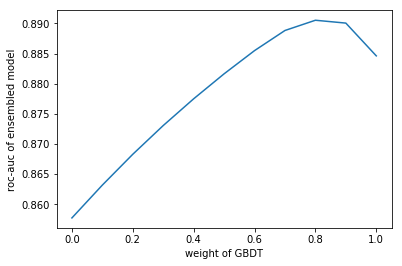

In [815]:
plt.plot(gbm_pcts, auc_esbs)
plt.xlabel('weight of GBDT')
plt.ylabel('roc-auc of ensembled model')

# 3. Bidding Strategy Selection


In [652]:
%run C_Bid_Strategy_Selection

In [549]:
# only payrice and click are relevant to bidding
payprice_valid = valid.payprice.values
click_valid = valid.click.values

In [550]:
# use average CTR of training dataset to estimated CTR in validation dataset
avg_ctr = np.sum(train['click']) / train.shape[0]
avg_ctr

0.0007375623256619447

In [579]:
# use ctr prediction from zonghan
y_pred_zh = pd.read_csv('./data/pred_dev_esm.csv')
y_pred_zh = np.array([p[0] for p in y_pred_zh.values])
roc_auc_score(valid['click'], y_pred_zh)

0.8793282460376302

In [620]:
# use my own ctr prediction
y_pred = pred_esb
roc_auc_score(valid['click'], y_pred)

0.8905354517435328

In [611]:
# re-calibrate
def re_calibrate(p , w):
    return p / (p + (1-p)/w)

In [621]:
# re-calibration
y_pred = [re_calibrate(p , w) for p in y_pred]
roc_auc_score(valid['click'], y_pred)


0.8905354517435328

In [817]:
roc_auc_score(valid['click'], y_pred)

0.8905354517435328

In [822]:
# # save to csv
# y_pred_df = pd.DataFrame(y_pred)
# y_pred_df.to_csv('./data/y_pred_valid.csv')

In [629]:
y_pred = np.array(y_pred)

In [622]:
stats(y_pred), stats(y_pred_zh)

mean: 0.0007437860898635258, min: 0.00014731705009131735, max: 0.013155023785198578
mean: 0.001076886429439099, min: 1.4272456400485166e-05, max: 0.3853249381516921


(None, None)

## 3.1 linear bidding 
Best click = 163
avg_ctr = 0.0007375623256619447
base_bid = 66 or 67

### 3.1.1 optimization

In [631]:
%%time
def interval_search_tmp(base_bids = np.linspace(0.294, 0.296, 21)):
    # visualize interval search
    clicks = []
    spents = []
    imps = []

    for b in base_bids:
        ## compute bids based on bidding strategy
        # calculate click gained
        bids_linear = linear_bid(b, y_pred, avg_ctr)
        # convert df to list
    #     bids_linear = [b[0] for b in bids_linear.values]
        accum_click, accum_imp, budget, i = count_click_numb(bids_linear, payprice_valid, click_valid)

        clicks.append(accum_click)
        spents.append(budget)
        imps.append(accum_imp)
        
    plot_interval_search(base_bids, clicks)
#     plt.axvline(x=base_bids[6], color='r')


CPU times: user 72 µs, sys: 5 µs, total: 77 µs
Wall time: 82.3 µs


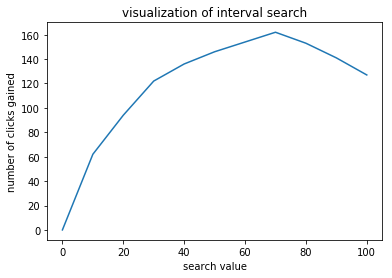

In [632]:
interval_search_tmp(base_bids = np.linspace(0, 100, 11))

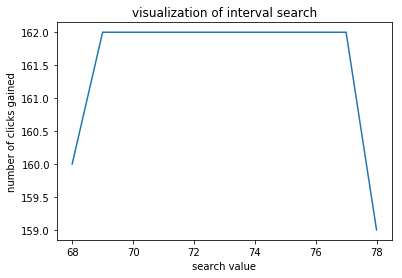

In [634]:
interval_search_tmp(base_bids = np.linspace(68, 78, 11))

### 3.1.2 analysis

In [699]:
# best linear bidding
bids_linear = linear_bid(76, y_pred, avg_ctr)
# cvt to list
# bids_linear_best = [b[0] for b in bids_linear_best.values]

# evaluation
count_click_numb(bids_linear, payprice_valid, click_valid)

(162, 143142, 112706, 303924)

In [343]:
# analyze bid portfolio:
stats(bids_linear_best)

mean: 97.82412721211797, min: 1.2965068111014082, max: 35002.83292397484


In [130]:
# range of actual payprice
np.min(train['payprice']), np.max(train['payprice'])

(0, 300)

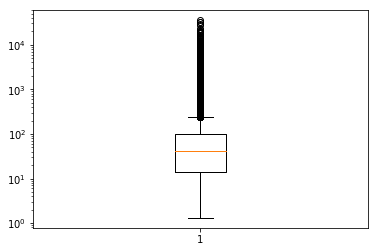

In [139]:
plt.boxplot(bids_linear)
plt.yscale('log', nonposy='clip')
# plt.title('Distriubtion of bids yield by linear bidding')
# # plt.xlabel('bidprice')
# plt.ylabel('bidprice')
# plt.axhline(y=300, color='r')
# plt.text(0.43,300,'300', color='r')

Text(0,0.5,'frequence')

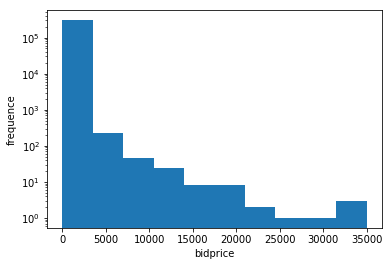

In [347]:
plt.hist(bids_linear_best)
plt.yscale('log', nonposy='clip')
# plt.title('Distriubtion of bids yield by linear bidding')
plt.xlabel('bidprice')
plt.ylabel('frequence')
# plt.axhline(y=300, color='r')
# plt.text(0.43,300,'300', color='r')

### 3.1.3 evaluation

{"ranking": 12, "group": "2", "result": {"impressions": 138502, "cost": 5805.815000002109, "clicks": 170, "ctr": 0.00122741909864117
49, "cpc": 34.15185294118888}, "daily submission limit": 3, "today tried times": 2, "best result": {"impressions": 102901, "cost": 6
190.209000001605, "clicks": 173, "ctr": 0.0016812275876813636, "cpc": 35.78155491330408}}

## 3.2 Round Bidding

## 3.2.1 Optimization

In [649]:
np.round_(4.500001)

5.0

In [650]:
%%time
def interval_search_tmp(base_bids = np.linspace(0,100,11)):
    # visualize interval search
    clicks = []
    spents = []
    imps = []

    for b in base_bids:
        ## compute bids based on bidding strategy
        # calculate click gained
        bids_round= round_bid(b, y_pred, avg_ctr)
        # convert df to list
    #     bids_linear = [b[0] for b in bids_linear.values]
        accum_click, accum_imp, budget, i = count_click_numb(bids_round, payprice_valid, click_valid)

        clicks.append(accum_click)
        spents.append(budget)
        imps.append(accum_imp)
        
    plot_interval_search(base_bids, clicks)
#     plt.axvline(x=base_bids[6], color='r')


CPU times: user 89 µs, sys: 13 µs, total: 102 µs
Wall time: 98.9 µs


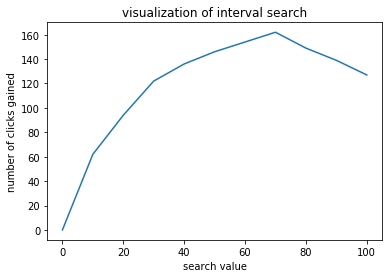

In [653]:
interval_search_tmp(base_bids = np.linspace(0,100,11))

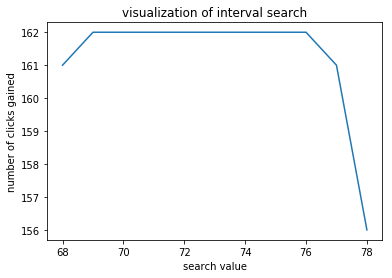

In [656]:
interval_search_tmp(base_bids = np.linspace(68,78,11))

In [695]:
# best roud bidding
bids_round= round_bid(76, y_pred, avg_ctr)
accum_click, accum_imp, left_budget, i = count_click_numb(bids_round, payprice_valid, click_valid)

In [696]:
# evaluate result
def evaluate_result(accum_click, accum_imp, left_budget, i):
    """
    further evaluation on bidding result
    Take output of count_click_numb() as input directly
    """

    Clicks = accum_click
    CTR = accum_click / accum_imp
    Spend = (6250 * 1000 - left_budget) / 1000
    avgCPM = Spend / accum_imp
    avgCPC = Spend / accum_click

    print('Clicks: {}; CTR: {}; Spend: {}; avgCPM: {}; avgCPC: {}'.format(Clicks, CTR, Spend, avgCPM, avgCPC))

In [697]:
evaluate_result(accum_click, accum_imp, left_budget, i )

Clicks: 162; CTR: 0.0011242504996668888; Spend: 6192.258; avgCPM: 0.04297314290473018; avgCPC: 38.223814814814816


## 3.2 Piecewise Bidding

In [701]:
# best linear bidding
bids_linear = linear_bid(76, y_pred, avg_ctr)
bids_linear
# # convert to list
# bids_linear = bids_linear.values
# bids_linear = [b[0] for b in bids_linear]

array([34.97152969, 32.59980604, 37.29211447, ..., 93.83073233,
       51.29904146, 56.34567722])

In [702]:
count_click_numb(bids_linear, payprice_valid, click_valid)

(162, 143142, 112706, 303924)

In [703]:
stats(bids_linear)

mean: 76.64130997864575, min: 15.179864016090963, max: 1355.5217950941455


Text(0,0.5,'frequence')

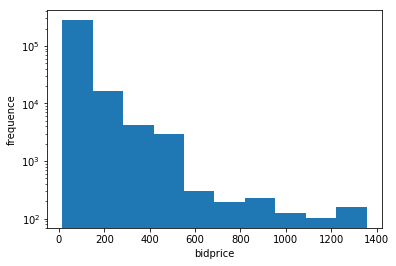

In [716]:
# 
plt.hist(bids_linear)
plt.yscale('log', nonposy='clip')
plt.xlabel('bidprice')
plt.ylabel('frequence')

In [731]:
def piecewise_bid(t, bids_linear, maxBid, maxPay):
    """
    refer to report for details
    """
    bids_pw = []
    for lb in bids_linear:
        if lb <= t:
            bid = lb
        else:
#             bid = (t-maxBid)/(t-maxPay)*lb -(t-maxBid)/(t-maxPay)*t + t
            bid = (t-maxPay)/(t-maxBid)*lb -(t-maxPay)/(t-maxBid)*t + t
    
        bids_pw.append(bid)
    
    return bids_pw

In [732]:
# pre-setted parameters
maxBid = 1356
maxPay = 300

In [739]:
bids_pw = piecewise_bid(260, bids_linear, maxBid, maxPay)
count_click_numb(bids_pw, payprice_valid, click_valid)

(160, 143062, 134830, 303924)

In [740]:
stats(bids_pw)

mean: 71.19628485608877, min: 15.179864016090963, max: 299.9825472662097


In [730]:
stats(bids_linear)

mean: 76.64130997864575, min: 15.179864016090963, max: 1355.5217950941455


In [ ]:
# optimize 

In [214]:
np.linspace(0, 299, 11)

array([  0. ,  29.9,  59.8,  89.7, 119.6, 149.5, 179.4, 209.3, 239.2,
       269.1, 299. ])

In [751]:
%%time
# visualize interval search
ts = np.linspace(260, 280, 20)
clicks_pw = []
spents_pw = []

for t in ts:
    ## compute bids based on bidding strategy
#     # linear bidding
#     bids_linear = linear_bid(b, y_pred, avg_ctr)
    
    # piecewise bidding
    bids_pw = piecewise_bid(t, bids_linear, maxBid, maxPay)
#     bids_pw = np.array(bids_pw)

    # calculate click gained
    accum_click_pw, accum_imp_pw, budget_pw, i_pw = count_click_numb(bids_pw, payprice_valid, click_valid)
    clicks_pw.append(accum_click_pw)
#     spents_pw.append(accum_imp_pw)


CPU times: user 14.7 s, sys: 127 ms, total: 14.9 s
Wall time: 14.9 s


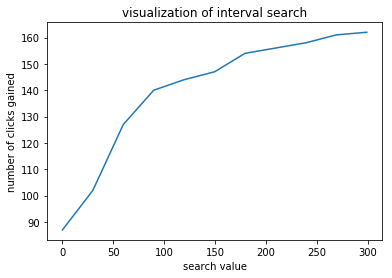

In [746]:
plot_interval_search(ts, clicks_pw)
# plt.axvline(x=base_bids[6], color='r')

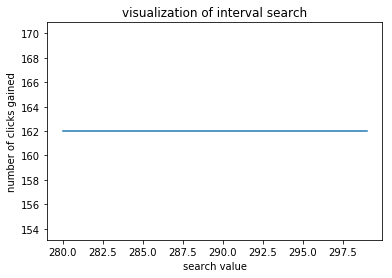

In [750]:
plot_interval_search(ts, clicks_pw)
# plt.axvline(x=base_bids[6], color='r')

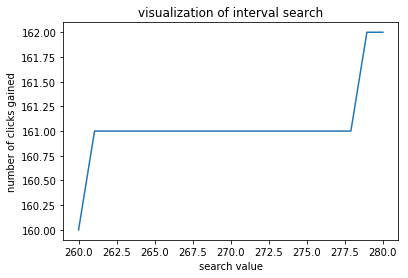

In [752]:
plot_interval_search(ts, clicks_pw)
# plt.axvline(x=base_bids[6], color='r')

In [249]:
%%time
# visualize interval search
ts = np.linspace(200, 299, 100)
clicks_pw = []
spents_pw = []

for t in ts:
    ## compute bids based on bidding strategy
#     # linear bidding
#     bids_linear = linear_bid(b, y_pred, avg_ctr)
    
    # piecewise bidding
    bids_pw = piecewise_bid(t, bids_linear, maxBid, maxPay)

    # calculate click gained
    accum_click_pw, accum_imp_pw, spent_pw = count_click_numb(bids_pw, payprice_valid, click_valid)
    clicks_pw.append(accum_click_pw)
    spents_pw.append(accum_imp_pw)


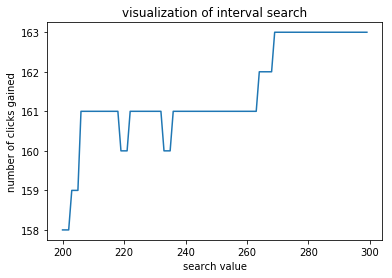

In [222]:
plot_interval_search(ts, clicks_pw)
# plt.axvline(x=base_bids[6], color='r')

In [253]:
%%time
# visualize interval search
ts = np.linspace(270, 299, 30)
clicks_pw = []
imps_pw = []

for t in ts:
    ## compute bids based on bidding strategy
#     # linear bidding
#     bids_linear = linear_bid(b, y_pred, avg_ctr)
    
    # piecewise bidding
    bids_pw = piecewise_bid(t, bids_linear, maxBid, maxPay)

    # calculate click gained
    accum_click_pw, accum_imp_pw, spent_pw = count_click_numb(bids_pw, payprice_valid, click_valid)
    clicks_pw.append(accum_click_pw)
    imps_pw.append(accum_imp_pw)


CPU times: user 20.5 s, sys: 77.8 ms, total: 20.6 s
Wall time: 20.6 s


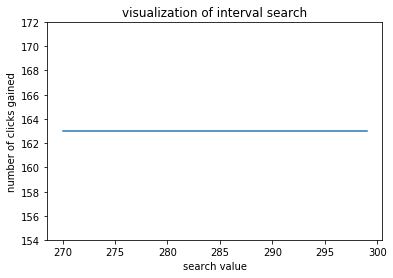

In [254]:
plot_interval_search(ts, clicks_pw)
# plt.axvline(x=base_bids[6], color='r')

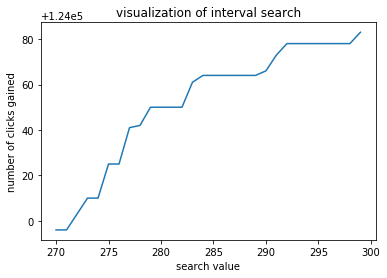

In [258]:
# number of impressions gained
plot_interval_search(ts, spents_pw)
# plt.axvline(x=base_bids[6], color='r')

## 3.3 Save-for-future bidding

if expected_spent > remain_budget * 10:
    D = 0.8
if expected_spent < remain_budget:
    D = 1.2


bidprice = estimated_price * D

In [262]:
# drawback of linear bidding: stop too early
count_click_numb(bids_linear, payprice_valid, click_valid)

(163, 124083, -84, 303608)

In [263]:
len(payprice_valid)

303925

## 3.4 Negative Exponential bidding
Avoid overly hight/low bidprice yield by linear bidding strategy

In [150]:
# simple negatice exponential bidding
def exp_bid(t, bids_linear):
    theta = -1.847

    bids_exp = []

    for bid in bids_linear:
        if bid <= t:
            bids_exp.append(bid)
        else:
            bids_exp.append(bid**theta)
    
    return bids_exp

In [198]:
bids_exp = exp_bid(2, bids_linear)
count_click_numb(bids_exp, payprice, click)

(0, 82, False)

In [162]:
stats(payprice)

mean: 78.23400509994242, min: 0, max: 300


In [164]:
stats(bids_linear)

mean: 98.83591679259393, min: 1.3099165099136865, max: 35364.86530442046


In [104]:
math.log(37684, 300)

1.8473689918905405

In [109]:
# find base of log
37684**(1/1.847)

300.34204370127605

In [108]:
300 ** (1.847)

37604.771792098785

In [100]:
# map the range of [1.4, 37683.9] to [0, 300]

In [102]:
math.log(37683.9, 300)

1.8473685266467057

## 3.5 squared-root bidding

In [66]:
# bid square rooted
base_bid = 80
bids_sqrt = square_root_bid(base_bid, y_pred, avg_ctr)
stats(bids_sqrt)

mean: 0    76.677703
dtype: float64, min: 0    11.128586
dtype: float64, max: 0    1828.538813
dtype: float64


# 4. Submit Result

In [367]:
def submission_gen(test, bids, file_name):
    result = pd.DataFrame()
    result['bidid'] = test['bidid']
    result['bidprice'] = bids
    result.to_csv(file_name, index=False)
    print('file generated: {}'.format(file_name))


In [637]:
# use ensemble model to predict ctr
pred_test = ensemble_gbm_lg(gbm_best_t, lg, X_test_t, X_test, 0.8)
# re-caliration
pred_test = [re_calibrate(p , w) for p in pred_test]
pred_test = np.array(pred_test)


array([112.13182326, 346.9308436 ,  24.91049632, ...,  55.6606359 ,
        98.78152893,  28.98360136])

In [827]:
# save to csv
pred_test_df = pd.DataFrame(pred_test)
pred_test_df.to_csv('./data/y_pred_test.csv')

In [658]:
# apply linear bidding
bids_linear_test = linear_bid(73, pred_test, avg_ctr)
bids_linear_test

array([112.13182326, 346.9308436 ,  24.91049632, ...,  55.6606359 ,
        98.78152893,  28.98360136])

{"ranking": 12, "group": "2", "result": {"impressions": 138502, "cost": 5805.815000002109, "clicks": 170, "ctr": 0.00122741909864117
49, "cpc": 34.15185294118888}, "daily submission limit": 3, "today tried times": 2, "best result": {"impressions": 102901, "cost": 6
190.209000001605, "clicks": 173, "ctr": 0.0016812275876813636, "cpc": 35.78155491330408}}

In [690]:
# apply round bidding
bids_round_test = round_bid(73, pred_test, avg_ctr)

{"ranking": 12, "group": "2", "result": {"impressions": 139439, "cost": 5858.616000002138, "clicks": 171, "ctr": 0.00122634270182660
51, "cpc": 34.26091228071426}, "daily submission limit": 3, "today tried times": 3, "best result": {"impressions": 102901, "cost": 6
190.209000001605, "clicks": 173, "ctr": 0.0016812275876813636, "cpc": 35.78155491330408}}

In [662]:
# cpm = (cost*100) / (impressions*1000)
cpm = 5858.616 / 139439
cpm

0.042015619733360106

TRY WITH LARGER BASE BID !!!

In [691]:
# apply round bidding with larger base bid
bids_round_test = round_bid(76, pred_test, avg_ctr)

{"ranking": 12, "group": "2", "result": {"impressions": 143774, "cost": 6162.3350000022865, "clicks": 173, "ctr": 0.0012032773658658
727, "cpc": 35.620433526024776}, "daily submission limit": 3, "today tried times": 1, "best result": {"impressions": 102901, "cost":
 6190.209000001605, "clicks": 173, "ctr": 0.0016812275876813636, "cpc": 35.78155491330408}}

In [694]:
# cpm = (cost*1000) / (impressions*1000)
cpm = 6162.335 / 143774
cpm

0.04286126142417961

In [778]:
# apply round bidding with even larger base bid
bids_round_test_80 = round_bid(80, pred_test, avg_ctr)

In [782]:
# apply round bidding with even larger base bid
bids_round_test_79 = round_bid(79, pred_test, avg_ctr)

result": {"impressions": 143091, "cost": 6249.999000002251, "clicks": 163, "ctr": 0.0011391352356192913, "cpc": 38.34355214725307}

In [781]:
stats(bids_round_test_80), stats(bids_round_test)

mean: 80.63437330037083, min: 16.0, max: 1399.0
mean: 76.60202060156571, min: 15.0, max: 1329.0


(None, None)

In [783]:
submission_gen(test, bids_round_test_79, './Submission/bids_round_test_79.csv')

file generated: ./Submission/bids_round_test_79.csv


In [639]:
submission_gen(test, bids_test, './Submission/gmb_lg_submit.csv')

file generated: ./Submission/gmb_lg_submit.csv


### submit result

In [ ]:
curl http://deepmining.cs.ucl.ac.uk/api/upload/wining_criteria_1/BSmn1t3iGH2F -X Post -F 'file=@./Submission/bids_round_test_79.csv'
    
    
    

In [ ]:
# submit result example
curl
http://deepmining.cs.ucl.ac.uk/api/upload/wining_criteria_1/HS72B2hs -X Post -F 'file=@./example_submission.csv'

# notes
* add slotid when using xgboost
* add ctr of each group as fature
* other bidding strategy: correct the mistake made in ctr prediction

In [63]:
valid.shape, test.shape

((303925, 25), (303375, 22))

In [761]:
data_tmp = train.copy()

In [762]:
data_tmp = cont_to_binarized_bin(data_tmp, cont_to_bin_cols, bins)

In [784]:
train_data.shape

(2430981, 708)

In [816]:
avg_ctr

0.0007375623256619447

Text(0,0.5,'frequency')

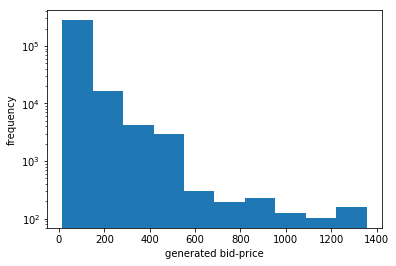

In [832]:
plt.hist(bids_linear)
plt.yscale('log', nonposy='clip')
plt.xlabel('generated bid-price')
plt.ylabel('frequency')
